In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

import extinction

from plotting_spectra import *

#plt.style.use('dark_background')

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [2]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
#lightcurves_alercextns

In [49]:
# Load all spectra info, metadata and data.
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240729_x_wisrep_20240622.pkl')

In [4]:
spectra_data.columns

Index(['oid', 'snname', 'instrument', 'mjd', 'lambda_grid_min',
       'lambda_grid_max', 'nlambda_grid', 'lambda_data_min', 'lambda_data_max',
       'flux_lambda', 'flux_lambda_smooth', 'e_flux_lambda'],
      dtype='object')

In [5]:
#CSP revisar estos espectros

In [6]:
spectra_metadata.columns

Index(['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [7]:
# Ver si los high, low, medium

In [8]:
spectra_metadata['Spec. quality'].value_counts()

Spec. quality
High      5671
Low       3125
Medium    2725
Name: count, dtype: int64

In [10]:
spectra_data['snname'].apply(lambda x: x.s)

0          SN2022pru
1          SN2022ytx
2          SN2022ytx
3        SNLS-07D3do
4        SNLS-07D3do
            ...     
25948      SN2021efd
25949      SN2020etk
25950      SN2020oqp
25951    SDSS-SN-082
25952       PTF12edl
Name: snname, Length: 25953, dtype: object

In [9]:
spectra_metadata[spectra_metadata['IAU name'] == 'SN 2019jyn']['Spec. quality'].value_counts()

Spec. quality
Medium    1
Name: count, dtype: int64

In [12]:
spectra_metadata['IAU name']

0          SN 1999Z
1          SN 1999Z
2          SN 1999Z
3          SN 1999Z
4          SN 1999Z
            ...    
46446    SN 2016hhv
46447    SN 2016hhv
46448    SN 2016hht
46449    SN 2016hhj
46450    SN 2016hhj
Name: IAU name, Length: 46451, dtype: object

In [52]:
spectra_metadata['IAU name'] = spectra_metadata['IAU name'].str.replace(' ', '')
spectra_metadata['IAU name']

0          SN1999Z
1          SN1999Z
2          SN1999Z
3          SN1999Z
4          SN1999Z
           ...    
46446    SN2016hhv
46447    SN2016hhv
46448    SN2016hht
46449    SN2016hhj
46450    SN2016hhj
Name: IAU name, Length: 46451, dtype: object

In [53]:
# List of supernova names with less than 5 spectra
supernovae_few_spectra = spectra_data['snname'].value_counts()[spectra_data['snname'].value_counts() >= 2].index
high_value_supernovae = spectra_metadata[spectra_metadata['Spec. quality'] == 'Medium']['IAU name']


supernoave_list_filter = list(set(supernovae_few_spectra) & set(high_value_supernovae))
supernoave_list_filter[:5]
# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

#spectra_data.lambda_data_min.quantile(0.1)

['SN2023upt', 'SN2021actu', 'SN2019odf', 'SN2021aczp', 'SN2020zpi']

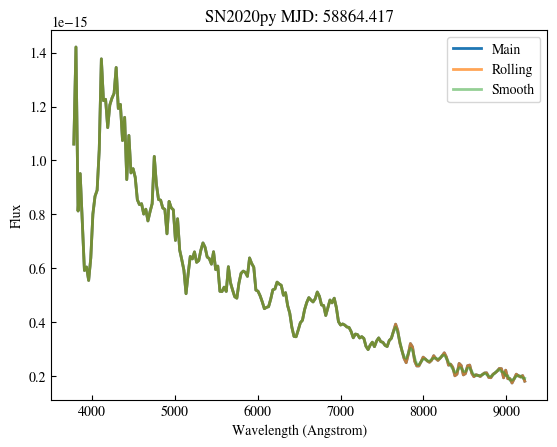

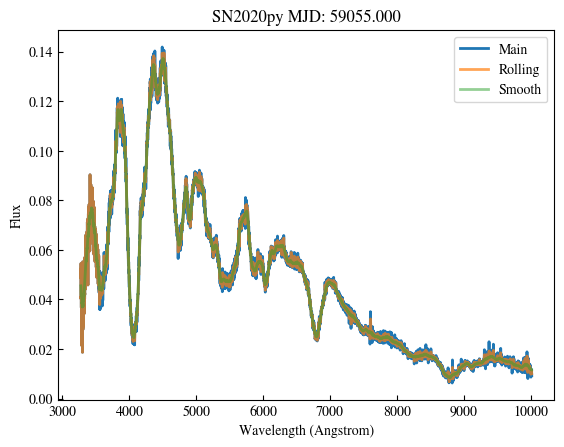

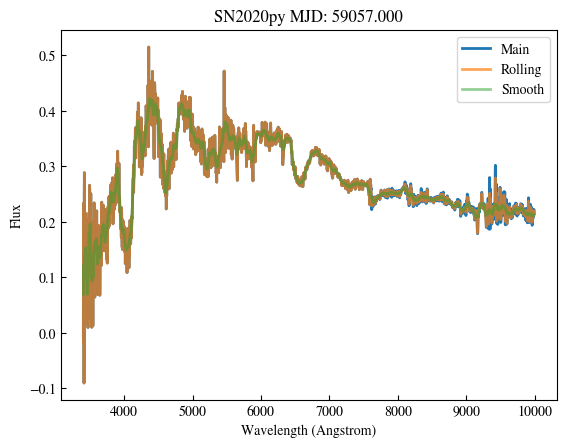

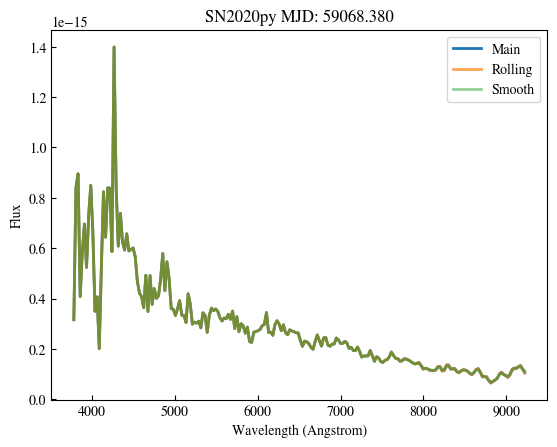

In [16]:
CSPEED = 3e5 # light_speed in km/s
dv = 200
dvsmooth = 2000
dlog10lambda = dv / CSPEED / np.log(10) * (24 * 3600) # pseudo seconds
dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

sn_name = 'SN2020py'
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    fig, ax = plt.subplots()
    wave = group['lambda'].to_numpy()

    group["log10lambda"] = np.log10(wave)

    # fool pandas to make it think log10lambda is days
    group["log10lambda_idx"] = group["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
    group.set_index("log10lambda_idx", inplace=True)

    # sorting the index
    group = group.sort_index()

    # obtain the flux rolled of the log_lambda
    group["flux_log10lambda_rolling"] = group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
    #delta = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    group["eflux_log10lambda_rolling"] = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()

    flux = group['flux_lambda'].to_numpy()
    ax.plot(wave, flux, label='Main')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()), alpha=0.7, label='Rolling')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()), alpha=0.5, label='Smooth')
    #ax.plot(wave, group['eflux_log10lambda_rolling'].to_numpy())
    ax.set_title(f'{sn_name} MJD: {group_name:.3f}')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Flux')
    ax.legend()

In [64]:
#spectrum = spectra_data[spectra_data.snname == np.random.choice(spectra_data.snname.unique())]
spectrum = spectra_data[spectra_data.snname.isin(supernoave_list_filter)]
spectrum = spectrum[spectrum.oid.notna()]
#spectrum = spectra_data[spectra_data.snname == 'SN2021ik']
spectrum = spectrum[spectrum.snname == np.random.choice(spectrum.snname.unique())]
spectrum

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,flux_lambda_smooth,e_flux_lambda
5837,ZTF19ablovot,SN2019mga,ESO-NTT_EFOSC2-NTT,58701.348805,3206.34,10915.01,1838,3644.047852,9239.227452,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.918509476261986e-18, 7.432358379472824e-18,..."
5838,ZTF19ablovot,SN2019mga,P60_SEDM,58705.501458,3206.34,10915.01,1838,3776.700000,9223.300000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [65]:
spectrum.mjd.value_counts()

mjd
58701.348805    1
58705.501458    1
Name: count, dtype: int64

5837    3.50601
Name: lambda_grid_min, dtype: float64
5838    3.50601
Name: lambda_grid_min, dtype: float64


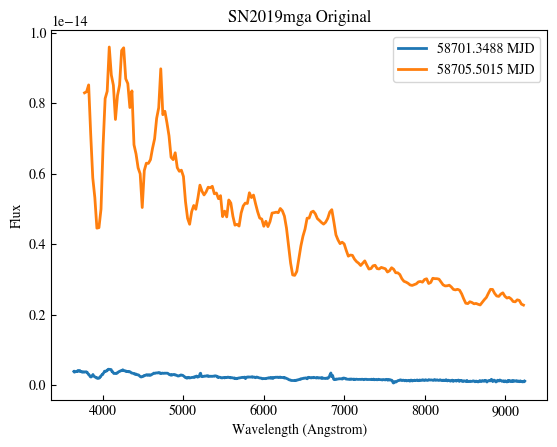

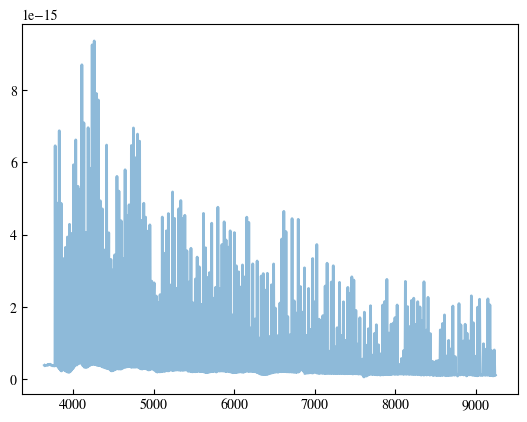

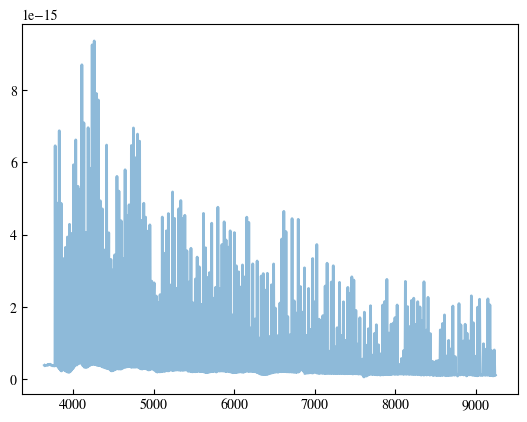

In [66]:
sn_name=spectrum.snname.unique()[0]
fig, ax = plt.subplots()
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    ax.plot(group['lambda'].to_numpy(), group.flux_lambda.to_numpy(), label=f'{group_name:.4f} MJD')
ax.set_title(f'{sn_name} Original')# MJD: {group_name:.3f}')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux')
ax.legend()


for group_name, group in spectrum.groupby('mjd'):
   fig, ax = plt.subplots()
   print(np.log10(group.lambda_grid_min))
   x = np.logspace(np.log10(group.lambda_grid_min), np.log10(group.lambda_grid_max),group.nlambda_grid.values[0])
   y = np.array(group.flux_lambda)[0]
   ax.plot(x, y, label=f'{group_name:.4f} MJD',alpha=0.5)

#plot_spectra(spectrum, use_lambda_grid=True, sn_name=sn_name)

In [12]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == spectrum.oid.unique()[0]]

In [13]:
wavelength_lsst = {'u':[3206.34, 4081.51], 'g':[3876.02, 5665.33], 'r':[5377.19, 7055.16],
                   'i':[6765.77, 8325.05], 'z':[8035.39, 9375.47], 'y':[9089.07, 10915.01]}

wavelength_ztf ={'g':[3676.00, 5613.82], 'r':[5497.60, 7394.40], 'i':[6870.97, 8964.61],}

ztf_sv_files  = [file for file in os.listdir('./data/') if 'Palomar' in file]
lsst_sv_files = [file for file in os.listdir('./data/') if 'LSST' in file]

ztf_sv_dict  = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in ztf_sv_files}
lsst_sv_dict = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in lsst_sv_files}

In [14]:
#grouped = raw_spectra.groupby('mjd').agg(list).reset_index()
# #grouped
# spectrum = raw_spectra.groupby('mjd').agg(list).reset_index()
# spectrum

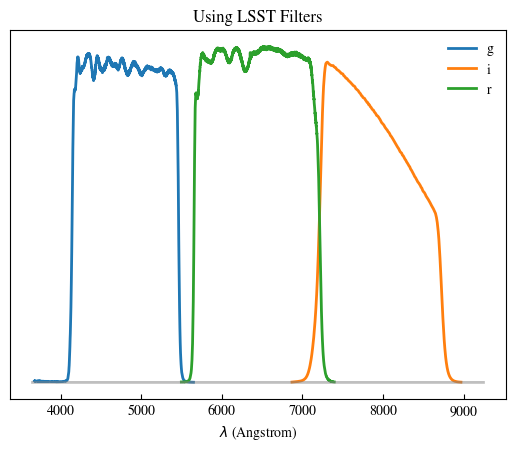

In [15]:
idx_spec = 0
fig, ax = plt.subplots()
#x_spectrum = np.array(spectrum.iloc[idx_spec]['lambda_'])

x_spectrum = np.logspace(np.log10(spectrum.iloc[idx_spec].lambda_grid_min),np.log10(spectrum.iloc[idx_spec].lambda_grid_max),len(spectrum.iloc[idx_spec].flux_lambda))
y_spectrum = np.array((spectrum.iloc[idx_spec]['flux_lambda'])) 

for band, sv in ztf_sv_dict.items():
    x, y = zip(*ztf_sv_dict[band])
    ax.plot(x,y,label=f'{band}')
ax.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
ax.set_xlabel(r'$\lambda$ (Angstrom)')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title('Using LSST Filters')
ax.legend(frameon=False)

plt.show()

In [16]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    #if delta_x == None:
    #    delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral

In [17]:
def obtain_magnitude_flux(spectrum:pd.DataFrame,instrument:str) -> dict:

    CSPEED = 3e8 # m/s

    if instrument == 'ztf':
        tranmision_dict = ztf_sv_dict
    elif instrument ==  'lsst':
        tranmision_dict = lsst_sv_dict

    x_spectrum = np.logspace(np.log10(spectrum.lambda_grid_min),np.log10(spectrum.lambda_data_max),spectrum.nlambda_grid)
    y_spectrum = np.array(spectrum.flux_lambda)
    f = interpolate.interp1d(x_spectrum,y_spectrum, fill_value=np.nan, bounds_error=False)
    #print(len(y_spectrum), len(x_spectrum))

    mags = {}   
    for band, s_wave in tranmision_dict.items():
        band, s_wave = band,s_wave
        wave, s_wave = zip(*tranmision_dict[band])
        wave, s_wave = np.array(wave), np.array(s_wave)

        #condition = np.where((min(wave) < x_spectrum) & (max(wave) > x_spectrum))
        #x = x_spectrum[condition]
        #y = y_spectrum[condition]
        
        flux_wave = f(wave)
        #flux_wave = y_spectrum

        log_nu = -np.log(wave)                           # Obtaining log_nu in lambda termns
        f_nu   = (wave**2/(CSPEED*1e10)) * flux_wave # Obtaining f_nu in lambda termns
        s_nu   = s_wave 

        num = np.trapz(f_nu*s_nu, dx=log_nu[:-1])
        den = np.trapz(s_nu, dx=log_nu[:-1])
        #print(f'Band = {band}')
        #print(f'num={num}, den={den}')
        num_test = simple_integration(wave,f_nu*s_nu, log_nu)
        den_test = simple_integration(wave,s_nu, log_nu)
        #print(f'num_test={num_test}, den_test={den_test}')
        m = -2.5 * np.log10(num_test/den_test) - 48.60
        #m = -2.5 * np.log10(num/den) - 48.60
        mags.update({band:m})
    print(mags)
    return mags

In [18]:
for _, row in spectrum.iterrows():
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)

NameError: name 'instrument' is not defined

{'g': 17.57781469229372, 'i': 18.315010575463482, 'r': 17.70055487728083}
{'g': 17.579757307234154, 'i': 18.338093322018032, 'r': 17.705354511954333}


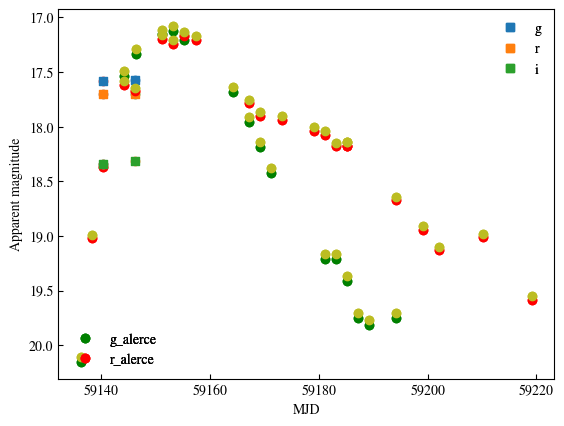

In [19]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ax = plt.subplots()
for _, row in spectrum.iterrows():
    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax.scatter(x=group.mjd, y=group.magpsf, color=color)
        ax.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color='C8')
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    try:
        magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    except:
        continue
    for bandapass, magnitude in magnitude_integrated.items():
        ax.scatter(row.mjd,magnitude)
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            #label = 
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax.legend(handles, bands, loc='upper right',frameon=False)
    ax.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax.add_artist(leg2)

    ax.yaxis.set_inverted(True)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    #ax.set_title(f'Light Curve {oid}')

In [20]:
# Agregar el 
# Verificar si estan fotocalibrados

In [21]:
redshift = spectra_metadata[spectra_metadata['IAU name'] == 'SN2021gd']['Redshift'].iloc[0]

{'g': 17.57781469229372, 'i': 18.315010575463482, 'r': 17.70055487728083}
{'g': 17.579757307234154, 'i': 18.338093322018032, 'r': 17.705354511954333}


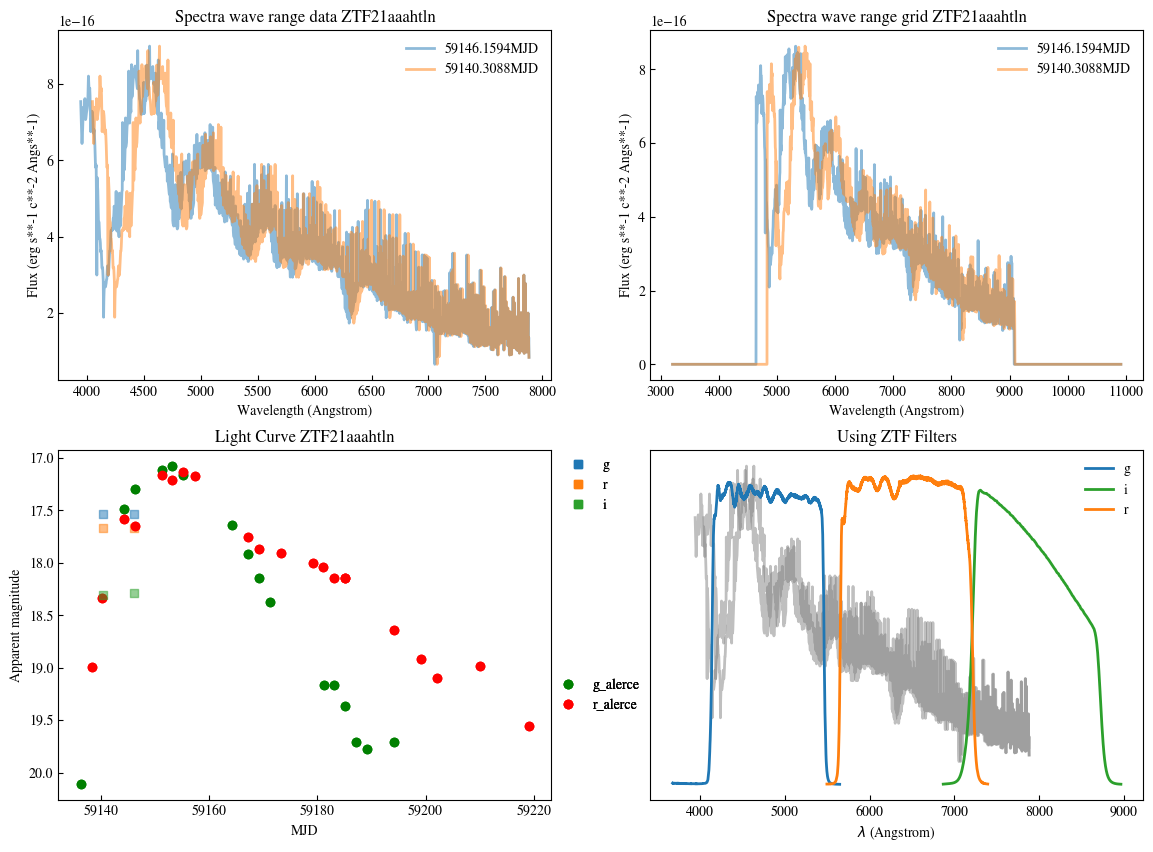

In [22]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14, 10))
oid = 'ZTF21aaahtln'
for _, row in spectrum.iterrows():

    # This calculate the x-axis and y-axis of the spectrum
    x_spectrum = np.linspace(row.lambda_data_min,row.lambda_data_max, len(row.flux_lambda))
    x_spectrum = x_spectrum / (1+redshift)
    y_spectrum = np.array(row.flux_lambda)    

    ax0.plot(x_spectrum, y_spectrum,label=f'{row.mjd:.4f}MJD', alpha=0.5)
    ax0.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax0.set_xlabel('Wavelength (Angstrom)')
    #ax1.text(x=max(x_spectrum)-500,
    #                 y=max(y_spectrum*2),
    #                 s=f'{row.mjd:.4f}MJD')
    ax0.set_title(f'Spectra wave range data {oid}')
    ax0.legend(frameon=False)

    x_spectrum_grid = np.linspace(row.lambda_grid_min,row.lambda_grid_max, row.nlambda_grid)
    y_spectrum_grid = interpolate_flux(row)
    ax1.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD', alpha=0.5)
    ax1.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax1.set_title(f'Spectra wave range grid {oid}')
    ax1.legend(frameon=False)

    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax2.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color=color)
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    for bandapass, magnitude in magnitude_integrated.items():
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if 'g' in bandapass else extinction.ccm89(wave, 0.0375, 3.1)[1]
            #label = 
            ax2.scatter(row.mjd,magnitude - extinction_correction, marker='s',color = color, alpha=0.5)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax2.scatter(row.mjd,magnitude, marker='s',color = color, alpha=0.5)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax2.legend(handles, bands, loc='center left', bbox_to_anchor=(1, 0.9),frameon=False)
    ax2.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax2.legend(handles, ['g_alerce', 'r_alerce'], loc = 'center left', bbox_to_anchor=(0.98, 0.3),frameon=False)
    ax2.add_artist(leg2)

    ax2.yaxis.set_inverted(True)
    ax2.set_xlabel('MJD')
    ax2.set_ylabel('Apparent magnitude')
    ax2.set_title(f'Light Curve {oid}')

    ax3.plot(x_spectrum, y_spectrum *1e15, alpha = 0.5, color='gray')
for band, sv in ztf_sv_dict.items():
    color = 'C0' if band == 'g' else 'C1' if band == 'r' else 'C2'
    x, y = zip(*ztf_sv_dict[band])
    ax3.plot(x,y,label=f'{band}', color=color)
ax3.set_xlabel(r'$\lambda$ (Angstrom)')
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title('Using ZTF Filters')
ax3.legend(frameon=False)
plt.show()

In [175]:
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum

In [29]:
spectrum_test = spectrum.iloc[0]
spectrum_test

oid                                                     ZTF19abcegvm
snname                                                     SN2019jyn
instrument                                        ESO-NTT_EFOSC2-NTT
mjd                                                     58782.169883
lambda_grid_min                                              3206.34
lambda_grid_max                                             10915.01
nlambda_grid                                                    1838
lambda_data_min                                          3648.047852
lambda_data_max                                          9243.227452
flux_lambda        [4.6887175e-17, 2.5313576e-17, 5.3807320000000...
e_flux_lambda      [1.4213047403500652e-17, 1.1642487660019164e-1...
Name: 15937, dtype: object

In [19]:
wavelength_spectrum_test = np.linspace(spectrum_test['lambda_data_min'],spectrum_test['lambda_data_max'], len(spectrum_test['flux_lambda']))
spectrum_fit = Spectrum1D(flux=np.array(spectrum_test['flux_lambda'])*(u.erg / u.s / u.cm**2 / u.AA), spectral_axis=wavelength_spectrum_test* u.AA)

In [20]:
g1_fit = fit_generic_continuum(spectrum_fit)
y_continuum_fitted = g1_fit(wavelength_spectrum_test*u.AA)

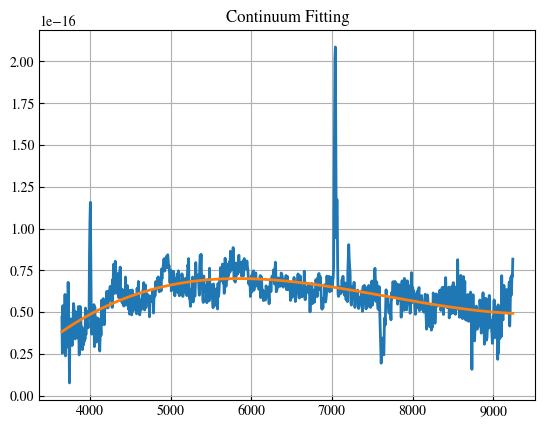

In [21]:
f, ax = plt.subplots()  
ax.plot(wavelength_spectrum_test, spectrum_test['flux_lambda'])  
ax.plot(wavelength_spectrum_test, y_continuum_fitted)  
ax.set_title("Continuum Fitting")  
ax.grid(True)  

In [22]:
spec_normalized = spectrum_fit / y_continuum_fitted

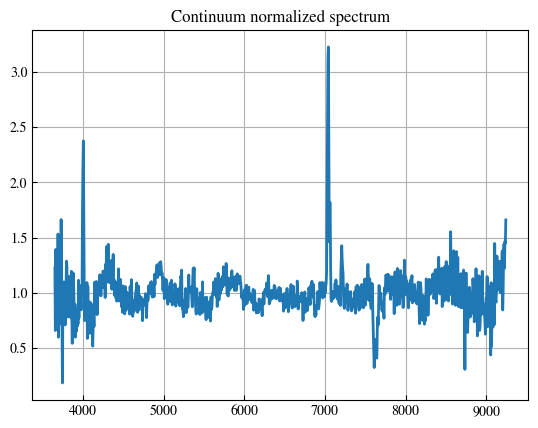

In [23]:
f, ax = plt.subplots()  
ax.plot(spec_normalized.spectral_axis, spec_normalized.flux)  
ax.set_title("Continuum normalized spectrum")  
ax.grid(True)  

In [ ]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [ ]:


# Av = 0.0375

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [ ]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    if delta_x == None:
        delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral